# Parkinson Disease Detection

This notebook demonstrates the development of a deep learning model for Parkinson's disease detection using medical images. Parkinson's disease is a neurodegenerative disorder that affects movement control, and early detection is crucial for treatment.

## Project Overview

-   **Input Data**: A dataset of images categorized as Normal or Parkinson's
-   **Preprocessing**: Resizing, normalization, and data augmentation
-   **Model Architecture**: Ensemble of EfficientNet-B0 and Vision Transformer (ViT)
-   **Training Approach**: Transfer learning with selective fine-tuning
-   **Evaluation**: Classification accuracy on validation set

## Technical Implementation

-   Data preprocessing and splitting into train/validation/test sets
-   Advanced data augmentation techniques to improve model generalization
-   Feature fusion from multiple deep learning models
-   Learning rate scheduling and regularization to prevent overfitting

## Model Architecture

The ensemble model combines features from:

-   **EfficientNet-B0**: Efficient CNN architecture for image feature extraction
-   **Vision Transformer**: Attention-based model that captures global image context

## Importing Required Libraries


In [1]:
import os
import shutil

import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTModel


In [2]:
def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)


base_dir = "./src/data/input/parkinsons_dataset"
normal_dir = os.path.join(base_dir, "normal")
parkinsons_dir = os.path.join(base_dir, "parkinson")

# Create train, validation and test directories
output_base_dir = "./src/data/working/processed_data"
train_dir = os.path.join(output_base_dir, "train")
val_dir = os.path.join(output_base_dir, "val")
test_dir = os.path.join(output_base_dir, "test")

for category in ["Normal", "Parkinson"]:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)


In [3]:
# Function to preprocess images
def preprocess_images(SOURCE, DEST, target_size=(224, 224)):
    for filename in os.listdir(SOURCE):
        img_path = os.path.join(SOURCE, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, target_size)
            img = img / 255.0  # Normalize to [0, 1]
            dest_img_path = os.path.join(DEST, filename)
            cv2.imwrite(dest_img_path, img * 255)  # Save the preprocessed image


# Helper function to copy files
def copy_file(file_name, src_dir, dest_dir):
    src = os.path.join(src_dir, file_name)
    dest = os.path.join(dest_dir, file_name)
    shutil.copyfile(src, dest)


# Function to split data into train, validation, and test sets
def split_data(SOURCE, TRAINING, VALIDATION, TEST, SPLIT_SIZE=0.7, VALID_SIZE=0.15, TEST_SIZE=0.15):
    all_files = []
    for file_name in os.listdir(SOURCE):
        file_path = os.path.join(SOURCE, file_name)
        if os.path.getsize(file_path) > 0:
            all_files.append(file_name)
        else:
            print(f"{file_name} is zero length, so ignoring.")

    train_set, temp_set = train_test_split(all_files, test_size=1 - SPLIT_SIZE)
    valid_set, test_set = train_test_split(temp_set, test_size=TEST_SIZE / (TEST_SIZE + VALID_SIZE))

    for file_name in train_set:
        copy_file(file_name, SOURCE, TRAINING)

    for file_name in valid_set:
        copy_file(file_name, SOURCE, VALIDATION)

    for file_name in test_set:
        copy_file(file_name, SOURCE, TEST)


# Visualize some images
def visualize_images(category, source_dir, num_images=5):
    plt.figure(figsize=(15, 5))
    for i, filename in enumerate(os.listdir(source_dir)[:num_images]):
        img_path = os.path.join(source_dir, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, num_images, i + 1)
            plt.imshow(img)
            plt.title(f"{category} - {i + 1}")
            plt.axis("off")
    plt.show()


[ WARN:0@8.952] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


Visualizing images from Normal


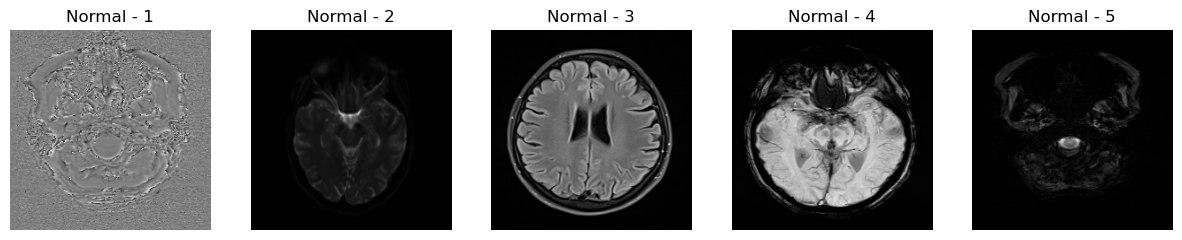

Visualizing images from Parkinson


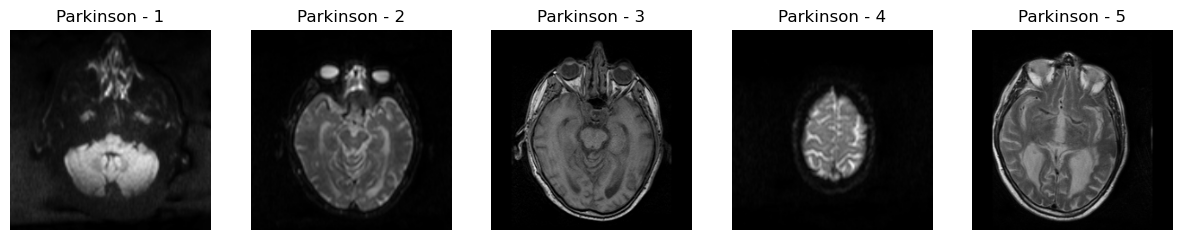

Data preprocessing and splitting completed.


In [4]:
# Process each category
for category, source_dir in [("Normal", normal_dir), ("Parkinson", parkinsons_dir)]:
    train_dest = os.path.join(train_dir, category)
    val_dest = os.path.join(val_dir, category)
    test_dest = os.path.join(test_dir, category)

    split_data(source_dir, train_dest, val_dest, test_dest)
    preprocess_images(train_dest, train_dest)
    preprocess_images(val_dest, val_dest)
    preprocess_images(test_dest, test_dest)

    # Visualize sample images
    print(f"Visualizing images from {category}")
    visualize_images(category, train_dest)

print("Data preprocessing and splitting completed.")


In [5]:
# Paths to the processed data directories
train_dir = "./src/data/working/processed_data/train"
val_dir = "./src/data/working/processed_data/val"
test_dir = "./src/data/working/processed_data/test"

# Choose device: GPU if available, else CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set basic parameters.
num_classes = 2
batch_size = 32  # Keep it consistent
epochs = 10
learning_rate = 1e-4


In [6]:
# Define transformations for PyTorch
transform_train = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),  # example "stronger" rotation
        transforms.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
        ),
        transforms.RandomAffine(
            degrees=0,
            translate=(0.2, 0.2),
            scale=(0.8, 1.2),
            shear=0.2,
        ),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

transform_val = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


In [7]:
# Create datasets and loaders once
train_dataset = ImageFolder(train_dir, transform=transform_train)
val_dataset = ImageFolder(val_dir, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training with {len(train_dataset)} images in {len(train_dataset.classes)} classes")
print(f"Class mapping: {train_dataset.class_to_idx}")

# Load the pre-trained EfficientNet and freeze its weights.
efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT).features.to(device)
for param in efficientnet.parameters():
    param.requires_grad = False

# Load the pre-trained ViT model and its feature extractor, and freeze its weights.
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224").to(device)
vit_feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
for param in vit_model.parameters():
    param.requires_grad = False

# Selectively unfreeze later layers of the models for fine-tuning
# For EfficientNet
for i, layer in enumerate(efficientnet):
    if i > 6:  # Unfreeze the last few layers
        for param in layer.parameters():
            param.requires_grad = True

# For ViT - unfreeze the last transformer blocks
for i, layer in enumerate(vit_model.encoder.layer):
    if i >= 9:  # Unfreeze the last 3 transformer blocks
        for param in layer.parameters():
            param.requires_grad = True


# Define an ensemble model.
class EnsembleModel(nn.Module):
    def __init__(self, num_classes):
        super(EnsembleModel, self).__init__()
        self.efficientnet = efficientnet
        self.vit = vit_model
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Add feature fusion layers instead of direct concatenation
        self.fusion = nn.Sequential(
            nn.Linear(1280 + 768, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x, vit_inputs):
        # EfficientNet branch.
        eff_features = self.efficientnet(x)
        eff_features = self.pool(eff_features)
        eff_features = torch.flatten(eff_features, start_dim=1)

        # Use precomputed inputs for ViT
        vit_outputs = self.vit(**vit_inputs).last_hidden_state[:, 0, :]

        # Combine features and pass through the final layer.
        features = torch.cat((eff_features, vit_outputs), dim=1)
        features = self.fusion(features)
        output = self.fc(features)
        return output


# Set up the model, loss function, and optimizer.
model = EnsembleModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    [
        {"params": model.fusion.parameters()},
        {"params": model.fc.parameters()},
        {
            "params": [p for p in model.efficientnet.parameters() if p.requires_grad],
            "lr": learning_rate / 10,
        },
        {
            "params": [p for p in model.vit.parameters() if p.requires_grad],
            "lr": learning_rate / 10,
        },
    ],
    lr=learning_rate,
    weight_decay=1e-5,
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=3, factor=0.5)

# Training loop.
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        # Preprocess for ViT before forward pass
        pil_images = []
        for img_tensor in images:
            pil_images.append(transforms.ToPILImage()(img_tensor.cpu()))
        vit_inputs = vit_feature_extractor(images=pil_images, return_tensors="pt")
        vit_inputs = {k: v.to(device) for k, v in vit_inputs.items()}

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images, vit_inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)

    # Validation phase.
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            pil_images = []
            for img_tensor in images:
                pil_images.append(transforms.ToPILImage()(img_tensor.cpu()))
            vit_inputs = vit_feature_extractor(images=pil_images, return_tensors="pt")
            vit_inputs = {k: v.to(device) for k, v in vit_inputs.items()}

            images, labels = images.to(device), labels.to(device)
            outputs = model(images, vit_inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total * 100.0
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Step the scheduler to adjust LR based on validation loss
    scheduler.step(avg_val_loss)

    torch.cuda.empty_cache()

print("Training finished!")

Training with 580 images in 2 classes
Class mapping: {'Normal': 0, 'Parkinson': 1}


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/mnt/a050bff2-5fd4-493b-8b69-04213baf9896/projects_secondary/parkinsons_disease_detection/.pixi/envs/default/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Epoch 1/10, Train Loss: 0.5377, Val Loss: 0.4593, Val Acc: 84.80%
Epoch 2/10, Train Loss: 0.3609, Val Loss: 0.3681, Val Acc: 84.00%
Epoch 3/10, Train Loss: 0.2354, Val Loss: 0.2291, Val Acc: 90.40%
Epoch 4/10, Train Loss: 0.1738, Val Loss: 0.1545, Val Acc: 96.00%
Epoch 5/10, Train Loss: 0.1203, Val Loss: 0.1042, Val Acc: 98.40%
Epoch 6/10, Train Loss: 0.0976, Val Loss: 0.0844, Val Acc: 98.40%
Epoch 7/10, Train Loss: 0.0635, Val Loss: 0.0716, Val Acc: 98.40%
Epoch 8/10, Train Loss: 0.0566, Val Loss: 0.0649, Val Acc: 98.40%
Epoch 9/10, Train Loss: 0.0555, Val Loss: 0.0619, Val Acc: 96.80%
Epoch 10/10, Train Loss: 0.0575, Val Loss: 0.0532, Val Acc: 97.60%
Training finished!


In [8]:
# Save the trained model.
# Create directory if it doesn't exist
os.makedirs("./src/data/models", exist_ok=True)

# Save full model (architecture + weights)
torch.save(model, "./src/data/models/ensemble_model_full.pt")

# Save state dict separately (current approach)
torch.save(model.state_dict(), "./src/data/models/ensemble_model.pth")

# Also save the feature extractor for inference
vit_feature_extractor.save_pretrained("./src/data/models/vit_feature_extractor")

print("Model saved to ./src/data/models")


Model saved to ./src/data/models
